In [2]:
###################################
#         INITIALISATION          #
###################################

# Importing libraries
import importlib.util
from collections import OrderedDict
from re import L
import matplotlib.pyplot as plt
import numpy as np

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win) 
spec_win.loader.exec_module(lumapi)

# Universal constants
mu0 = 4*np.pi * 10**(-7) # vacuum permeability
eps0 =  8.8541878128 * 10**(-12) # vacuum permittivity
c = 3*10**8 # speed of light


### Run box below to run simulations (without retrieving any data from lumerical to python)

In [30]:
with lumapi.MODE(hide=False) as mode:

    ###########################
    # Global variables & FDTD #
    ###########################

    material = mode.addmaterial("Dielectric")
    material_name = "LiNbO3"
    mode.setmaterial(material, "name", material_name)
    mode.setmaterial(material_name, "refractive index", 2.211)

    base_angle = 70
    base_width = 0.845e-6 # base width of top waveguide
    upper_height = 0.3e-6 # height of etched part of the waveguide
    lower_height = 0e-6 # height of non-etched part of the waveguide (note that total upper + lower height shouldn't exceed 300nm)
    waveguide_margin = 0e-6 # width of the bottom non-etched waveguide that is in excess compared to the upper waveguide
    x_span = 20e-6
    gap = 0.1e-6
    coupler_length = 0e-6
    radius = 10e-6

    material_waveguide = material_name
    material_substrate = "SiO2 (Glass) - Palik"

    m = 0.55191502449 # The cubic Bezier curve using this magic number in the pole points approximates the semi-circle with least error
    
    ###################
    # Structure group #
    ###################
    
    # This structure group allows for simultaneous changing of parameters when conducting sweeps
    
    mode.addstructuregroup()
    mode.set("name","waveguides")
    mode.set("x", 0)
    mode.set("y", 0)
    mode.set("z",0)
    mode.adduserprop("base width",2,base_width) # 2 is for length type
    mode.adduserprop("upper height",2,upper_height)
    mode.adduserprop("lower height",2,lower_height)
    mode.adduserprop("waveguide margin",2,waveguide_margin)
    mode.adduserprop("gap",2,gap)
    mode.adduserprop("radius",2,radius)
    mode.adduserprop("coupler length",2,coupler_length)
    setup_code = open('waveguides_structuregroup.lsf', 'r').read()
    mode.set('script',setup_code)

    x = mode.get("x")
    y = mode.get("y")

    #############
    # Substrate #
    #############

    substrate = mode.addrect(x = 0, y = 0, z = -1e-6,
                            x_span = 2*2*radius,
                            y_span = 2*2*radius,
                            z_span = 2.0e-6,
                            material = material_substrate
                            #material = "<Object defined dielectric>",
                            #index = 1.4
                            )
    mode.addtogroup("::model::waveguides")

    ##############################
    # Waveguide & Ring resonator #
    ##############################

    # Add upper bottom left portion of ring resonator
    poles=np.asarray([[-coupler_length/2-radius, 0],
                      [-coupler_length/2-radius,-radius*m],
                      [-coupler_length/2-radius*m,-radius],
                      [-coupler_length/2,-radius]])
    ring_upper_left_bottom = mode.addwaveguide(x=x, y=y, z=lower_height + upper_height/2, 
                            base_width=base_width, base_height=upper_height, base_angle=base_angle,
                            name = "rulb", poles = poles,
                            material = material_waveguide
                            #material = "<Object defined dielectric>",
                            #index = 3.5
    )
    mode.addtogroup("::model::waveguides")

    # Add lower bottom left portion of ring resonator
    poles=np.asarray([[-coupler_length/2-radius, 0],
                      [-coupler_length/2-radius,-radius*m],
                      [-coupler_length/2-radius*m,-radius],
                      [-coupler_length/2,-radius]])
    ring_lower_left_bottom = mode.addwaveguide(x=x, y=y, z=lower_height/2, 
                            base_width=base_width + waveguide_margin, base_height=lower_height, base_angle=90,
                            name = "rllb", poles = poles,
                            material = material_waveguide
                            #material = "<Object defined dielectric>",
                            #index = 3.5
    )
    mode.addtogroup("::model::waveguides")

    # Add upper bottom right portion of ring resonator
    poles=np.asarray([[coupler_length/2+radius, 0],
                      [coupler_length/2+radius,-radius*m],
                      [coupler_length/2+radius*m,-radius],
                      [coupler_length/2,-radius]])
    ring_upper_right_bottom = mode.addwaveguide(x=x, y=y, z=lower_height + upper_height/2, 
                            base_width=base_width, base_height=upper_height, base_angle=base_angle,
                            name = "rurb", poles = poles,
                            material = material_waveguide
                            #material = "<Object defined dielectric>",
                            #index = 3.5
    )
    mode.addtogroup("::model::waveguides")

    # Add lower bottom right portion of ring resonator
    poles=np.asarray([[coupler_length/2+radius, 0],
                      [coupler_length/2+radius,-radius*m],
                      [coupler_length/2+radius*m,-radius],
                      [coupler_length/2,-radius]])
    ring_lower_right_bottom = mode.addwaveguide(x=x, y=y, z=lower_height/2, 
                            base_width=base_width + waveguide_margin, base_height=lower_height, base_angle=90,
                            name = "rlrb", poles = poles,
                            material = material_waveguide
                            #material = "<Object defined dielectric>",
                            #index = 3.5
    )
    mode.addtogroup("::model::waveguides")
    
    #######
    # FDE #
    #######
    FDE_yspan = base_width*5
    FDE_zspan = (lower_height + upper_height)*5
    mesh_cells_y = 300
    mesh_cells_z = 200
    
    mode.addfde()
    mode.set("solver type",1) # 1 for 2D X Normal
    mode.set("x",x)
    mode.set("y",-radius)
    mode.set("y span",FDE_yspan)
    mode.set("z",(lower_height + upper_height)/2)
    mode.set("z span",FDE_zspan)
    mode.set("mesh cells y", mesh_cells_y)
    mode.set("mesh cells z", mesh_cells_z)
    mode.set("y min bc", "PML")
    mode.set("y max bc", "PML")
    mode.set("z min bc", "PML")
    mode.set("z max bc", "PML")

    mode.select("FDE::data")
    mode.addanalysisprop("base width", 2, base_width) # 2 for length type
    mode.addanalysisprop("gap", 2, gap)
    mode.addanalysisprop("radius", 2, radius)
    mode.addanalysisprop("lower height", 2, lower_height)
    mode.addanalysisprop("upper height", 2, upper_height)
    mode.addanalysisprop("base angle", 0, base_angle) # 0 for number type
    mode.addanalysisprop("waveguide margin", 2, waveguide_margin)
    mode.addanalysisprop("coupler length", 2, coupler_length)
    mode.addanalysisprop("mesh cells y", 0, mesh_cells_y)
    mode.addanalysisprop("mesh cells z", 0, mesh_cells_z)
    mode.addanalysisprop("FDE y span", 2, FDE_yspan)
    mode.addanalysisprop("FDE z span", 2, FDE_zspan)
    mode.addanalysisresult("ratio")
    mode.addanalysisresult("loss")

    setup_code = open('integral_ratio_analysis.lsf', 'r').read()
    mode.set('analysis script',setup_code)

    ###########################
    # Run and save simulation #
    ###########################
    #mode.findmodes()
    mode.save("LiNbO3 simulation 15_1.fsp")

    ###################
    # Parameter sweep #
    ###################

    def sweep(name_of_parameter, number_of_points, start, stop):
        # Create sweep
        name_of_sweep = str(name_of_parameter) + "_sweep"

        mode.addsweep(0) # 0 is for sweep
        mode.setsweep("sweep", "name", name_of_sweep)
        mode.setsweep(str(name_of_parameter) + "_sweep", "type", "Ranges")
        mode.setsweep(str(name_of_parameter) + "_sweep", "number of points", number_of_points)
        
        # Define and add the parameter to the sweep
        para = {}
        para["Name"] = name_of_parameter
        para["Parameter"] = "::model::waveguides::" + str(name_of_parameter)
        para["Type"] = "Length"
        para["Start"] = start
        para["Stop"] = stop
        para["Units"] = "microns"
        mode.addsweepparameter(name_of_sweep, para)

        para_FDE = {}
        para_FDE["Name"] = str(name_of_parameter) + " FDE"
        para_FDE["Parameter"] = "::model::FDE::data::" + str(name_of_parameter)
        para_FDE["Type"] = "Length"
        para_FDE["Start"] = start
        para_FDE["Stop"] = stop
        para_FDE["Units"] = "microns"
        mode.addsweepparameter(name_of_sweep, para_FDE)

        # Define and add ratio as a sweep result
        result_ratio = {}
        result_ratio["Name"] = "ratio"
        result_ratio["Result"] = "::model::FDE::data::ratio"
        mode.addsweepresult(name_of_sweep, result_ratio)

        # Define and add loss as a sweep result
        result_loss = {}
        result_loss["Name"] = "loss"
        result_loss["Result"] = "::model::FDE::data::loss"
        mode.addsweepresult(name_of_sweep, result_loss)

        # Run sweep
        mode.runsweep(name_of_sweep)

    sweep(name_of_parameter = "base width", number_of_points = 50, start = 1.5e-6, stop = 3.5e-6)
    #sweep(name_of_parameter = "upper height", number_of_points = 20, start = 0.2e-6, stop = 0.7e-6)

    ##########################
    # Parameter optimization #
    ##########################
    
    def optimise(fom, max_generations, generation_size, base_width_start, base_width_stop, upper_height_start, upper_height_stop):
        # Creating the optimisation
        name_of_optimisation = "loss_optimisation"

        mode.addsweep(1) # 1 is for optimisation
        mode.setsweep("optimization", "name", name_of_optimisation)
        mode.setsweep(name_of_optimisation, "Type", "Maximize") if fom == "ratio" else mode.setsweep(name_of_optimisation, "Type", "Minimize")
        mode.setsweep(name_of_optimisation, "algorithm", "Particle Swarm")
        mode.setsweep(name_of_optimisation, "maximum generations", max_generations)
        mode.setsweep(name_of_optimisation, "generation size", generation_size)
        mode.setsweep(name_of_optimisation, "tolerance", 0)

        # Define and add base width to the sweep
        para = {}
        para["Parameter"] = "::model::waveguides::base width" 
        para["Type"] = "Length"
        para["Min"] = base_width_start
        para["Max"] = base_width_stop
        para["Units"] = "microns"
        mode.addsweepparameter(name_of_optimisation, para)

        # Define and add base width to the sweep
        para = {}
        para["Parameter"] = "::model::waveguides::upper height" 
        para["Type"] = "Length"
        para["Min"] = upper_height_start
        para["Max"] = upper_height_stop
        para["Units"] = "microns"
        mode.addsweepparameter(name_of_optimisation, para)

        # Define and add ratio as an optimisation result
        result_ratio = {}
        result_ratio["Name"] = "ratio"
        result_ratio["Result"] = "::model::FDE::data::ratio"
        result_ratio["Optimize"] = True if fom == "ratio" else False
        mode.addsweepresult(name_of_optimisation, result_ratio)

        # Define and add loss as an optimisation result
        result_loss = {}
        result_loss["Name"] = "loss"
        result_loss["Result"] = "::model::FDE::data::loss"
        result_loss["Optimize"] = True if fom == "loss" else False
        mode.addsweepresult(name_of_optimisation, result_loss)

        
        # Run optimization
        mode.runsweep(name_of_optimisation)
        
    #optimise(fom = "loss", max_generations = 20, generation_size = 10, base_width_start = 0.5e-6, base_width_stop = 1e-6, upper_height_start = 0e-6, upper_height_stop = 0.3e-6)



### Run box below to plot ratio vs upper height graphs for various base widths (multiple sweep simulations)

base width = 750 nm
Highest ratio = 1.860282856887364
Highest ratio when height = 546.9387755102041 nm
 
base width = 800 nm
Highest ratio = 1.5282357598736815
Highest ratio when height = 557.142857142857 nm
 
base width = 850 nm
Highest ratio = 2.4888793935336904
Highest ratio when height = 587.7551020408163 nm
 
base width = 900 nm
Highest ratio = 3.7379015234444597
Highest ratio when height = 628.5714285714284 nm
 
base width = 950 nm
Highest ratio = 5.782429915141617
Highest ratio when height = 669.3877551020407 nm
 
base width = 1000 nm
Highest ratio = 8.554462115455248
Highest ratio when height = 700.0 nm
 


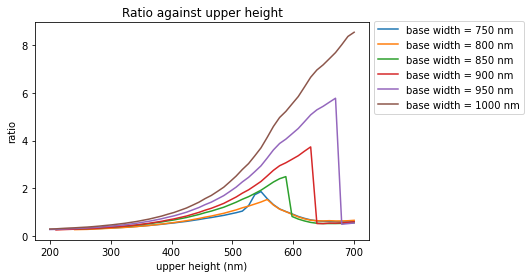

In [61]:
number_of_sweeps = 6 # change the number in range to the number of sweeps conducted

ratio_all = []
para_all = []
base_widths = []

for i in range(number_of_sweeps): 
    mode = lumapi.MODE(f"LiNbO3 simulation 7_{i+1}.fsp") # change name of file
    R = mode.getsweepresult("upper height_sweep","ratio")
    mode.select("waveguides")
    base_width = int(mode.get("base width") * 1e9)
    base_widths.append(base_width)

    ratio = list(R['ratio'])
    para = list(R['upper height'][0])
    ratio_truncated = list(filter(lambda x: x > 0, ratio)) # remove data points where mode is unguided
    para_truncated = list(filter(lambda x: ratio[para.index(x)] > 0, para)) # remove data points where mode is unguided

    ratio_all.append(ratio_truncated)
    para_all.append(para_truncated)

for i in range(number_of_sweeps):
    plt.plot(np.array(para_all[i]) * 1e9, ratio_all[i], label = f"base width = {base_widths[i]} nm")

    highest_ratio = max(ratio_all[i])
    para_highest_ratio = para_all[i][np.where(ratio_all[i] == highest_ratio)[0][0]] * 1e9
    print(f"base width = {base_widths[i]} nm")
    print(f"Highest ratio = {highest_ratio}")
    print(f"Highest ratio when height = {para_highest_ratio} nm")
    print(" ")
    
plt.xlabel("upper height (nm)")
plt.ylabel("ratio")
plt.title("Ratio against upper height")
plt.legend(bbox_to_anchor=(1, 1.03))
plt.show()

### Run box below to plot loss vs base widths graphs for various lower heights (multiple sweep simulations)

lower height = 0 nm
Lowest loss = 146.19694680551484 dB/cm
Lowest loss when base width = 3500.0 nm
 
lower height = 50 nm
Lowest loss = 145.39276707992508 dB/cm
Lowest loss when base width = 3500.0 nm
 
lower height = 100 nm
Lowest loss = 142.68905196500228 dB/cm
Lowest loss when base width = 3500.0 nm
 
lower height = 150 nm
Lowest loss = 133.4810951053675 dB/cm
Lowest loss when base width = 3500.0 nm
 


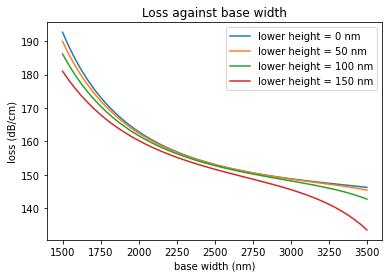

In [31]:
number_of_sweeps = 4 # change the number in range to the number of sweeps conducted

loss_all = []
para_all = []
lower_heights = []

for i in range(number_of_sweeps): 
    mode = lumapi.MODE(f"LiNbO3 simulation 15_{i+1}.fsp") # change name of file
    R = mode.getsweepresult("base width_sweep","loss")
    mode.select("waveguides")
    lower_height = int(mode.get("lower height") * 1e9)
    lower_heights.append(lower_height)

    loss = list(R['loss'] * 1e-2)
    para = list(R['base width'][0])
    loss_truncated = list(filter(lambda x: x ,loss)) # remove data points where loss >= 1dB/cm
    para_truncated = list(filter(lambda x: loss[para.index(x)], para)) # remove data points where loss >= 1dB/cm

    loss_all.append(loss_truncated)
    para_all.append(para_truncated)

for i in range(number_of_sweeps):
    plt.plot(np.array(para_all[i]) * 1e9, loss_all[i], label = f"lower height = {lower_heights[i]} nm")
    plt.legend()

    lowest_loss = min(loss_all[i])
    para_lowest_loss = para_all[i][np.where(loss_all[i] == lowest_loss)[0][0]] * 1e9
    print(f"lower height = {lower_heights[i]} nm")
    print(f"Lowest loss = {lowest_loss} dB/cm")
    print(f"Lowest loss when base width = {para_lowest_loss} nm")
    print(" ")
    
plt.xlabel("base width (nm)")
plt.ylabel("loss (dB/cm)")
plt.title("Loss against base width")
#plt.legend(bbox_to_anchor=(1, 1.03))
plt.show()

### Run box below to plot ratio vs base width for a single sweep simulation

Highest ratio = 0.4571172302170598
Highest ratio when width = 1500.0 nm
 


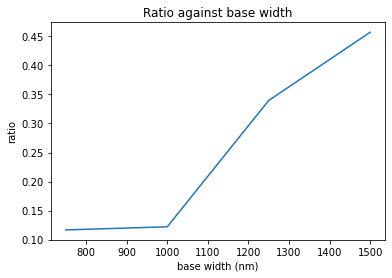

In [10]:
mode = lumapi.MODE(f"LiNbO3 simulation 14.fsp")
R = mode.getsweepresult("base width_sweep","ratio")

ratio = list(R['ratio'])
para = list(R['base width'][0])
ratio_truncated = list(filter(lambda x: x > 0,ratio)) # remove data points where mode is unguided
para_truncated = list(filter(lambda x: ratio[para.index(x)] > 0, para)) # remove data points where mode is unguided
plt.plot(np.array(para_truncated) * 1e9, ratio_truncated)

highest_ratio = max(ratio_truncated)
para_highest_ratio = para_truncated[np.where(ratio_truncated == highest_ratio)[0][0]] * 1e9
print(f"Highest ratio = {highest_ratio}")
print(f"Highest ratio when width = {para_highest_ratio} nm")
print(" ")
    
plt.xlabel("base width (nm)")
plt.ylabel("ratio")
plt.title("Ratio against base width")
plt.show()

### Run box below to plot loss vs base width for a single sweep simulation

Lowest loss = 142.68905196500228 dB/cm
Lowest loss when width = 3500.0 nm
 
Lowest positive loss = 142.68905196500228 dB/cm
Lowest positive loss when width = 3500.0 nm
 


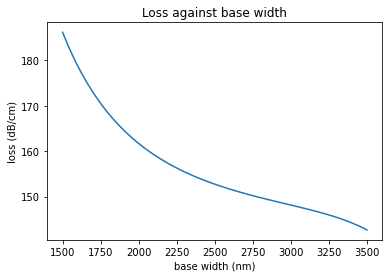

In [28]:
mode = lumapi.MODE(f"LiNbO3 simulation 15_3.fsp")
R = mode.getsweepresult("base width_sweep","loss")

loss = list(R['loss'] *1e-2)
para = list(R['base width'][0])
loss_truncated = list(filter(lambda x: x != 999.99,loss)) # remove data points where loss >= 1dB/cm
para_truncated = list(filter(lambda x: abs(loss[para.index(x)]) != 999.99, para)) # remove data points where loss >= 1dB/cm

plt.plot(np.array(para_truncated) * 1e9, loss_truncated)

lowest_loss = min(loss_truncated)
para_lowest_loss = para_truncated[np.where(loss_truncated == lowest_loss)[0][0]] * 1e9
lowest_positive_loss = min(list(filter(lambda x: x>= 0, loss_truncated)))
para_lowest_positive_loss = para_truncated[np.where(loss_truncated == lowest_positive_loss)[0][0]] * 1e9
print(f"Lowest loss = {lowest_loss} dB/cm")
print(f"Lowest loss when width = {para_lowest_loss} nm")
print(" ")
print(f"Lowest positive loss = {lowest_positive_loss} dB/cm")
print(f"Lowest positive loss when width = {para_lowest_positive_loss} nm")
print(" ")
    
plt.xlabel("base width (nm)")
plt.ylabel("loss (dB/cm)")
plt.title("Loss against base width")
plt.show()

### Run box below to plot optimisation results

Lowest loss = 79.96146994726656 dB/cm
Best base width = 1000.0 nm
Best upper height = 300.00 nm


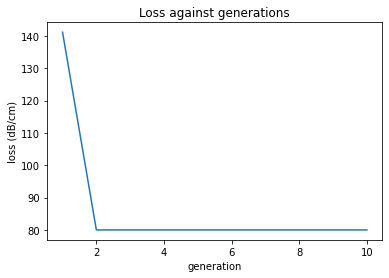

In [87]:
mode = lumapi.MODE(f"LiNbO3 simulation 9.fsp")
best_fom = mode.getsweepresult("loss_optimisation","best fom")['fom'] * 1e-2
fom = mode.getsweepresult("loss_optimisation","fom trend")
params = mode.getsweepresult("loss_optimisation","best parameters")

generation = fom['generation']
loss = np.array(fom['fom']) * 1e-2
plt.plot(generation, loss)
plt.xlabel("generation")
plt.ylabel("loss (dB/cm)")
plt.title("Loss against generations")

best_base_width = params['parameter value'][0] * 1e9
best_upper_height = params['parameter value'][1] * 1e9

print(f"Lowest loss = {best_fom} dB/cm")
print(f"Best base width = {best_base_width} nm")
print(f"Best upper height = {best_upper_height:.2f} nm")

### Index matrix stuff

In [54]:
#mode = lumapi.MODE("LiNbO3 simulation 7.fsp")

R = mode.getresult("FDE::data::material","index")
index_x = np.squeeze(R["index_x"])
index_y = np.squeeze(R["index_y"])
index_z = np.squeeze(R["index_z"])
print(False in index_x == index_z)
print(index_x.shape)
print(R['y'].shape)
print(R['z'].shape)

print(np.unique(index_x,return_index= True))

False
(173, 73)
(173, 1)
(73, 1)
(array([1.        , 1.05257136, 1.05257136, 1.10290353, 1.10290353,
       1.21496889, 1.24636381, 1.29746197, 1.29746197, 1.34282315,
       1.4440023 , 1.52384289, 1.59856448, 1.59856448, 1.72717854,
       1.72717854, 1.78257448, 1.78257448, 1.87479748, 1.94929093,
       2.01790277, 2.01790277, 2.14063074, 2.14063074, 2.17138171,
       2.17138171, 2.211     ]), array([  32, 5291, 7335, 7194, 5442, 5215,   31, 5366, 7264, 5516,    0,
       5290, 7193, 5441, 5662, 5589, 5365, 7263, 5287, 5289, 7192, 5440,
       7262, 5364, 5515, 7121, 5214], dtype=int64))
